In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [3]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")
pd.Series(dtype='float64')
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [5]:
train_df, test_df = train_test_split(
    all_df,
    train_size=0.8,
    shuffle=True,
    random_state=1
)

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,GlobalAveragePooling2D,Flatten,LSTM,TimeDistributed,Reshape

#CNN

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(120,120,3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu') )
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Reshape((1, -1)))


In [9]:


# Add LSTM Layer
model.add(LSTM(128))

# Add Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

In [11]:
history_cnnlstm = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 195s 228ms/step - loss: 0.1446 - accuracy: 0.9289 - val_loss: 0.0432 - val_accuracy: 0.9852
Epoch 2/100
800/800 [==============================] - 63s 78ms/step - loss: 0.0473 - accuracy: 0.9838 - val_loss: 0.0395 - val_accuracy: 0.9867
Epoch 3/100
800/800 [==============================] - 63s 79ms/step - loss: 0.0392 - accuracy: 0.9864 - val_loss: 0.0282 - val_accuracy: 0.9908
Epoch 4/100
800/800 [==============================] - 61s 77ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0297 - val_accuracy: 0.9906
Epoch 5/100
800/800 [==============================] - 62s 77ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0271 - val_accuracy: 0.9922
Epoch 6/100
800/800 [==============================] - 63s 78ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0138 - val_accuracy: 0.9950
Epoch 7/100
800/800 [==============================] - 62s 78ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0120 - val_

In [17]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"],digits=4)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.00815
Test Accuracy: 99.79%
250/250 [==============================] - 15s 60ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


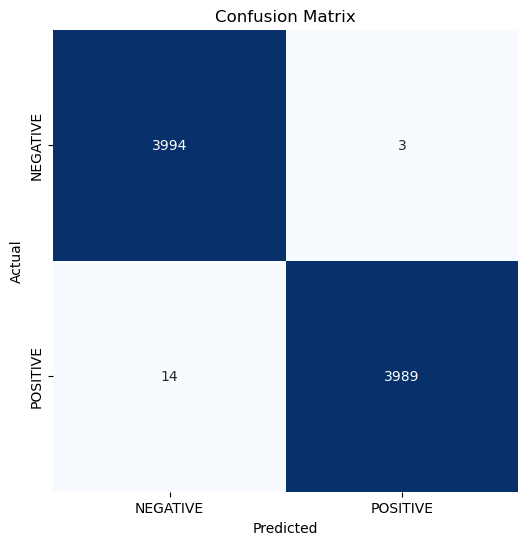

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE     0.9965    0.9992    0.9979      3997
    POSITIVE     0.9992    0.9965    0.9979      4003

    accuracy                         0.9979      8000
   macro avg     0.9979    0.9979    0.9979      8000
weighted avg     0.9979    0.9979    0.9979      8000



In [18]:
evaluate_model(model, test_data)

In [14]:
model.predict(test_data)

250/250 [==============================] - 15s 60ms/step


array([[2.9166962e-05],
       [9.9140781e-01],
       [4.5265506e-06],
       ...,
       [9.9984944e-01],
       [2.0411071e-05],
       [3.9795659e-06]], dtype=float32)

In [15]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/test-img/Cracked-Concrete-Foundation.jpg')
pred = model.predict(image)


if pred < 0.5:
    print("No Crack")
else:
    print("Crack")
    

1/1 [==============================] - 0s 479ms/step
Crack


In [16]:
model.save("lstm_cnn_model.h5")